#### Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [99]:
import numpy as np  # library to handle data in a vectorized manner

import pandas as pd  # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests  # library to handle requests

from bs4 import BeautifulSoup  # library used for scraping

import texttable as tt  # library to print data as a table

from sklearn.cluster import KMeans  # import k-means from clustering stage

import folium  # map rendering library

from geopy.geocoders import Nominatim  # convert an address into latitude and longitude values

import json # library to handle JSON files

import seaborn as sns 

from matplotlib import pyplot as plt
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#### Request then parse the contents of the website

In [3]:
response = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(response.text, "html.parser")  # pass the html object and the type of parser as arguments

#### Scrape the data from the wikipedia page and print the table to confirm if the required data is obtained 

In [168]:
# soup.find_all will scrape every element in the table

table_data = iter(soup.find_all('td'))
data = []

# This loop will keep repeating till there is data available in the iterator
while True:
    try:
        postal_code = next(table_data).text
        borough = next(table_data).text
        neighborhood = next(table_data).text

        data.append([postal_code, borough, neighborhood])

    # Exception will occur when there are no more elements left to iterate through
    except StopIteration:
        break


#### Convert the data to a pandas data frame 

In [169]:
df_postal = pd.DataFrame(data)
df_postal.columns =["Postal Code", "Borough", "Neighborhood"]  # set the column names
cols_to_check = ['Postal Code','Borough', 'Neighborhood']
df_postal[cols_to_check] = df_postal[cols_to_check].replace({'\n':''}, regex=True)  # remove "/n" character from every cell
df_postal = df_postal.iloc[:180] 
df_postal.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [37]:
df_postal.loc[df_postal['Neighborhood']=="Not assigned",'Neighborhood']=df_postal.loc[df_postal['Neighborhood']=="Not assigned",'Borough']
df_postal.rename(columns = {'Neighborhood':'Neighborhoods'}, inplace = True) 
df_postal.head()

,Postal Code,Borough,Neighborhoods
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Read the data

In [148]:
df_COVID19 = pd.read_csv('Toronto_COVID-19.csv')
df_COVID19.head()

,CDN,Neighborhood,Case Count,"Rate per 100,000 people"
0,129.0,Agincourt North,79,271.356439
1,128.0,Agincourt South-Malvern West,52,218.882856
2,20.0,Alderwood,40,331.840053
3,95.0,Annex,83,271.899364
4,42.0,Banbury-Don Mills,37,133.598122


In [149]:
df_CDN = pd.read_excel('Wikipedia_Toronto_Neighborhoods.xlsx','Sheet1')
df_CDN.head()

,CDN,Neighborhood,Borough
0,129.0,Agincourt North,Scarborough
1,128.0,Agincourt South- Malvern West,Scarborough
2,20.0,Alderwood,Etobicoke
3,95.0,Annex,Old City of Toronto
4,42.0,Banbury-Don Mills,North York


In [150]:
df_cases = pd.read_csv('COVID19 cases.csv')
df_cases.sort_values('Reported Date', inplace=True)
df_cases.head()

,Age Group,Neighbourhood Name,Postal Code,Episode Date,Reported Date,Client Gender
3660,50-59,Willowdale East,M2N,2020-01-21,2020-01-23,MALE
3661,50-59,Willowdale East,M2N,2020-01-22,2020-01-23,FEMALE
3947,20-29,Parkwoods-Donalda,M3A,2020-02-05,2020-02-21,FEMALE
7035,60-69,Church-Yonge Corridor,M4W,2020-02-16,2020-02-25,FEMALE
7034,60-69,Church-Yonge Corridor,M4W,2020-02-20,2020-02-26,MALE


#### Read the geographical coordinates of each postal code

In [41]:
geo_coord = pd.read_csv('https://cocl.us/Geospatial_data')
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### Merge all the data frames

In [42]:
df_comb = pd.merge(df_postal, geo_coord, on='Postal Code')
df_comb.head()

,Postal Code,Borough,Neighborhoods,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [152]:
df_comb2 = pd.merge(df_COVID19, df_CDN, on='CDN')
df_comb2.head()

,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Neighborhood,Borough
0,129.0,Agincourt North,79,271.356439,Agincourt North,Scarborough
1,128.0,Agincourt South-Malvern West,52,218.882856,Agincourt South- Malvern West,Scarborough
2,20.0,Alderwood,40,331.840053,Alderwood,Etobicoke
3,95.0,Annex,83,271.899364,Annex,Old City of Toronto
4,42.0,Banbury-Don Mills,37,133.598122,Banbury-Don Mills,North York


In [153]:
df_merged = pd.merge(df_comb, df_comb2, on='Borough')

df_merged.head()

,Postal Code,Borough,Neighborhoods,Latitude,Longitude,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Neighborhood
0,M3A,North York,Parkwoods,43.753259,-79.329656,42.0,Banbury-Don Mills,37,133.598122,Banbury-Don Mills
1,M3A,North York,Parkwoods,43.753259,-79.329656,34.0,Bathurst Manor,126,793.800794,Bathurst Manor
2,M3A,North York,Parkwoods,43.753259,-79.329656,52.0,Bayview Village,33,154.234436,Bayview Village
3,M3A,North York,Parkwoods,43.753259,-79.329656,49.0,Bayview Woods-Steeles,116,881.861031,Bayview Woods- Steeles
4,M3A,North York,Parkwoods,43.753259,-79.329656,39.0,Bedford Park-Nortown,81,348.597005,Bedford Park- Nortown


#### Get the total number of cases per episode date

In [14]:
total_cases = df_cases['Episode Date'].value_counts()
total_cases = pd.DataFrame(total_cases)
total_cases.reset_index(level=0, inplace=True)
total_cases.columns = ['Episode Date','Total Cases']
total_cases.sort_values('Episode Date',inplace=True)
total_cases.head()

,Episode Date,Total Cases
146,2020-01-21,1
148,2020-01-22,1
147,2020-02-01,1
138,2020-02-05,1
144,2020-02-07,1


In [15]:
df_cases =pd.merge(total_cases,df_cases,on='Episode Date')
df_cases.head()

,Episode Date,Total Cases,Age Group,Neighbourhood Name,Postal Code,Reported Date,Client Gender
0,2020-01-21,1,50-59,Willowdale East,M2N,2020-01-23,MALE
1,2020-01-22,1,50-59,Willowdale East,M2N,2020-01-23,FEMALE
2,2020-02-01,1,70-79,Waterfront Communities-The Island,M5A,2020-05-25,MALE
3,2020-02-05,1,20-29,Parkwoods-Donalda,M3A,2020-02-21,FEMALE
4,2020-02-07,1,50-59,Moss Park,M5A,2020-04-13,MALE


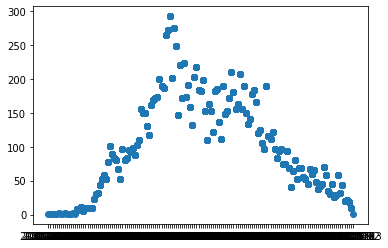

In [16]:
plt.scatter(df_cases['Episode Date'],df_cases['Total Cases'])
# This shows us that the relationship is not linear and the cases already reached their peak!

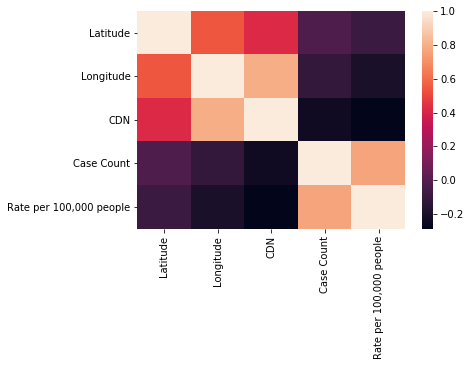

In [18]:
cor = df_merged.corr()
sns.heatmap(cor)

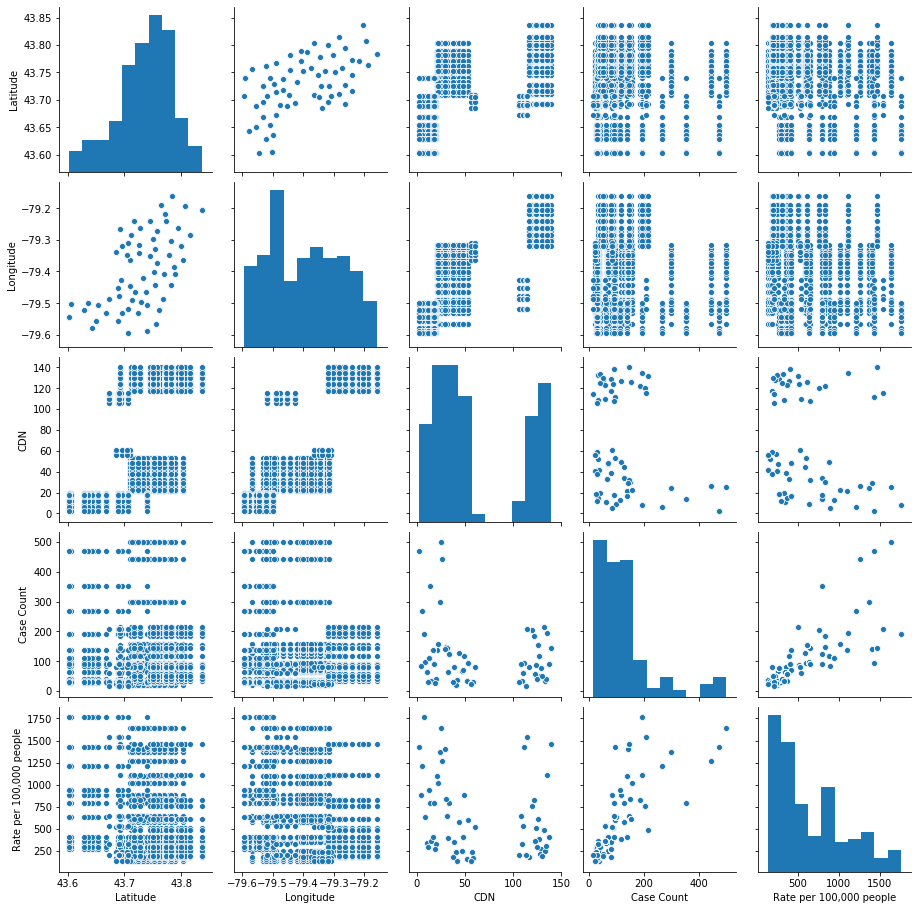

In [19]:
sns.pairplot(df_merged)

#### Use geopy library to get the latitude and longitude values of Toronto

In [20]:
address = 'Toronto ON'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top

In [22]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(
        df_comb['Latitude'], 
        df_comb['Longitude'], 
        df_comb['Borough'], 
        df_comb['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

#### Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = 'TKXS2XMWIT30VQAEBAL4AV05WLKRG2Q0AL35LWTCUE3SP4WQ' # your Foursquare ID
CLIENT_SECRET = 'FVADZBSYOGMTT2BJTJ0KD0QWAAG4AGE5DL2JAJA1HXASFV54' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Explore a neighborhood in our dataframe

In [84]:
df_merged.loc[2, 'Neighborhood']

'Bayview\xa0Village'

#### Get the neighborhood's latitude and longitude values.

In [85]:
neighborhood_latitude = df_merged.loc[2, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_merged.loc[2, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_merged.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bayview Village are 43.7532586, -79.3296565.


#### Now, let's get the top venues that are in Bayview Village within a radius of 500 meters.

In [86]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [87]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Clean the json and structure it into a pandas dataframe

In [88]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Toronto but to search for hospitals

In [133]:
def getNearbyVenues(names, latitudes, longitudes, radius=100):
    
    categoryId = '4bf58dd8d48988d196941735'
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        
        # return only relevant information for each nearby venue
    venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    return(nearby_venues.head(5))

## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters

In [157]:
df_features = df_merged[['Rate per 100,000 people','Case Count']]
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_features)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

df_merged['Cluster Labels'] = kmeans.labels_

In [158]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Examine Clusters

#### Cluster 0

In [164]:
df_merged.drop('Neighborhood', axis=1, inplace=True)
df_merged.loc[df_merged['Cluster Labels'] == 0, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Borough,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Cluster Labels
1,North York,34.0,Bathurst Manor,126,793.800794,0
3,North York,49.0,Bayview Woods-Steeles,116,881.861031,0
7,North York,30.0,Brookhaven-Amesbury,148,833.474123,0
16,North York,21.0,Humber Summit,137,1103.414948,0
17,North York,22.0,Humbermede,158,1016.403988,0
21,North York,34.0,Bathurst Manor,126,793.800794,0
23,North York,49.0,Bayview Woods-Steeles,116,881.861031,0
27,North York,30.0,Brookhaven-Amesbury,148,833.474123,0
36,North York,21.0,Humber Summit,137,1103.414948,0
37,North York,22.0,Humbermede,158,1016.403988,0


#### Cluster 1

In [165]:
df_merged.loc[df_merged['Cluster Labels'] == 1, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Borough,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Cluster Labels
0,North York,42.0,Banbury-Don Mills,37,133.598122,1
2,North York,52.0,Bayview Village,33,154.234436,1
4,North York,39.0,Bedford Park-Nortown,81,348.597005,1
6,North York,41.0,Bridle Path-Sunnybrook-York Mills,22,237.427153,1
8,North York,33.0,Clanton Park,65,394.609034,1
9,North York,47.0,Don Valley Village,68,251.377029,1
15,North York,48.0,Hillcrest Village,70,413.369552,1
18,North York,38.0,Lansing-Westgate,30,185.597624,1
20,North York,42.0,Banbury-Don Mills,37,133.598122,1
22,North York,52.0,Bayview Village,33,154.234436,1


#### Cluster 2

In [166]:
df_merged.loc[df_merged['Cluster Labels'] == 2, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Borough,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Cluster Labels
5,North York,24.0,Black Creek,299,1375.534802,2
10,North York,26.0,Downsview-Roding-CFB,443,1263.836586,2
13,North York,25.0,Glenfield-Jane Heights,499,1636.548490,2
19,North York,29.0,Maple Leaf,142,1404.411037,2
25,North York,24.0,Black Creek,299,1375.534802,2
30,North York,26.0,Downsview-Roding-CFB,443,1263.836586,2
33,North York,25.0,Glenfield-Jane Heights,499,1636.548490,2
39,North York,29.0,Maple Leaf,142,1404.411037,2
45,North York,24.0,Black Creek,299,1375.534802,2
50,North York,26.0,Downsview-Roding-CFB,443,1263.836586,2


#### Cluster 3

In [167]:
df_merged.loc[df_merged['Cluster Labels'] == 3, df_merged.columns[[1] + list(range(5, df_merged.shape[1]))]]

,Borough,CDN,Neighborhood,Case Count,"Rate per 100,000 people",Cluster Labels
11,North York,32.0,Englemount-Lawrence,145,648.131593,3
12,North York,44.0,Flemingdon Park,128,583.595495,3
14,North York,53.0,Henry Farm,94,597.850283,3
31,North York,32.0,Englemount-Lawrence,145,648.131593,3
32,North York,44.0,Flemingdon Park,128,583.595495,3
34,North York,53.0,Henry Farm,94,597.850283,3
51,North York,32.0,Englemount-Lawrence,145,648.131593,3
52,North York,44.0,Flemingdon Park,128,583.595495,3
54,North York,53.0,Henry Farm,94,597.850283,3
71,North York,32.0,Englemount-Lawrence,145,648.131593,3


### From the clusters we can tell that neighborhoods in cluster 1 are "Least Infected" and neighborhoods in cluster 2 are "Extremely Infected"